In [1]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

# Question 1

In [2]:
def read_file(filename):
    return pd.read_csv(os.getcwd()+"/data/"+filename, sep=" ", header=0, names=["x0","x1","y"])

In [3]:
df = read_file("D2z.txt")

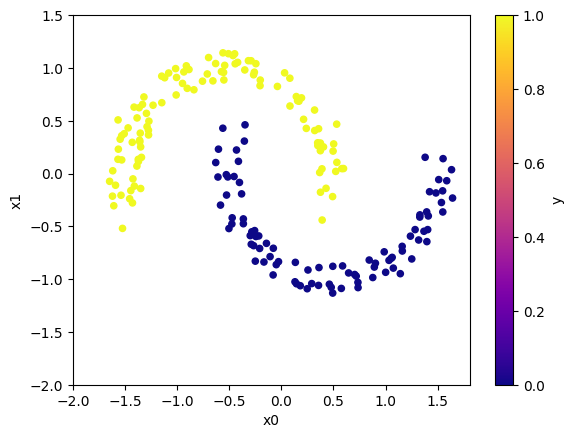

In [4]:
ax1 = df.plot.scatter(x="x0",y="x1",c="y",colormap="plasma")
plt.xticks(np.arange(-2,2, 0.5))
plt.yticks(np.arange(-2,2,0.5))
plt.show()

In [5]:
def get_NN(df,v):
    df["distance_"] = np.sqrt((df["x0"]-v[0])**2 + (df["x1"]-v[1])**2)
    return df.iloc[[df.idxmin()["distance_"]]]

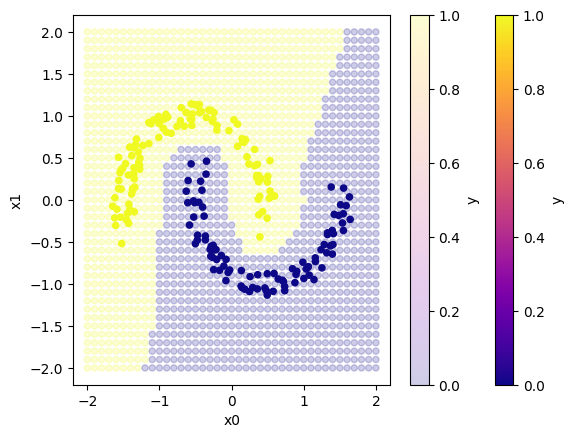

In [6]:
pts = []
for x0 in np.arange(-2,2.1,0.1):
    for x1 in np.arange(-2,2.1,0.1):
        pts.append([x0,x1,get_NN(df,[x0,x1]).iloc[0]["y"]])
        
nn_df = pd.DataFrame(pts)
nn_df.columns = ["x0","x1","y"]

fig, ax = plt.subplots()

df.plot.scatter(x="x0",y="x1",c="y",colormap="plasma", ax=ax)
nn_df.plot.scatter(x="x0",y="x1",c="y",colormap="plasma", alpha=0.2, ax=ax)

plt.savefig("Q1-plot.png")
plt.show()

# Question 2

In [7]:
# returns dataframe of data after dropping email No. column
def read_file(filename):
    df = pd.read_csv(os.getcwd()+"/data/"+filename, sep=",")
    return df.drop(df.columns[0], axis=1)

# return data with indices between a and b as test_df and all other data as data_df
# drops the prediction column from both dataframes
def split_data(df, a, b):    
    train_x_df = df.drop(df.index[range(a,b)])
    train_y_df = train_x_df.loc[:,"Prediction"]
    train_x_df = train_x_df.drop(train_x_df.columns[-1], axis=1)

    
    test_x_df = df.drop(df.index[range(0,a)]).drop(df.index[range(b,len(df.index))])
    test_y_df = test_x_df.loc[:,"Prediction"]
    test_x_df = test_x_df.drop(test_x_df.columns[-1], axis=1)
    
    return train_x_df, test_x_df, train_y_df, test_y_df

# returns the index of the k nearest neighbors as an array
def get_nns(train_x_df, test_x_df, k):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='brute').fit(train_x_df)
    return nbrs.kneighbors(test_x_df)[1]
        
# returns 0 or 1 if return_confidence is set to false
# otherwise returns a confidence in interval [0,1]
def get_prediction(train_y_df, nns, i, return_confidence=False):
    
    pos_predictions = 0
    for j in range(len(nns[i])):
        if train_y_df.iloc[nns[i][j]]:
            pos_predictions += 1
        
    if not return_confidence:
        if pos_predictions/len(nns[i]) > 0.5:
            prediction = 1
        else:
            prediction = 0
        return prediction
    
    
    return pos_predictions/len(nns[i])

# numerator: (TP + TN)
# denominator: (all datapoints)
def get_accuracy(train_y_df, nns, a):

    num_correct = 0
    for i in range(len(nns)):
        real_val = df.iloc[i+a]["Prediction"]
        prediction = get_prediction(train_y_df, nns, i)
        
        if real_val and prediction:
            num_correct += 1
        if not real_val and not prediction:
            num_correct += 1

    return num_correct / 1000

# numerator: (TP)
# denominator: (TP + FP)
def get_precision(train_y_df, nns, a):
    tp = 0
    fp = 0
    
    for i in range(len(nns)):
        real_val = df.iloc[i+a]["Prediction"]
        prediction = get_prediction(train_y_df, nns, i)
        
        if real_val and prediction:
            tp += 1
        if not real_val and prediction:
            fp += 1
    
    return tp/(tp+fp)

# numerator: (tp)
# denominator: (tp + fn)
def get_recall(train_y_df, nns, a):
    tp = 0
    fn = 0
    
    for i in range(len(nns)):
        real_val = df.iloc[i+a]["Prediction"]
        prediction = get_prediction(train_y_df, nns, i)
        
        if real_val and prediction:
            tp += 1
        if real_val and not prediction:
            fn += 1
    
    return tp/(tp + fn)

In [8]:
df = read_file("emails.csv")
folds = [[0,1000],[1000,2000],[2000,3000],[3000,4000],[4000,5000]]

k=1
for fold in folds:
    a = fold[0]
    b = fold[1]
    
    train_x_df, test_x_df, train_y_df, test_y_df = split_data(df, a, b)
    nns = get_nns(train_x_df, test_x_df, k)
    
    accuracy = get_accuracy(train_y_df, nns, a)
    precision = get_precision(train_y_df, nns, a)
    recall = get_recall(train_y_df, nns, a)
    
    print("accuracy: " + str(accuracy))
    print("precision: " + str(precision))
    print("recall: " + str(recall))
    print("---")

accuracy: 0.825
precision: 0.6544943820224719
recall: 0.8175438596491228
---
accuracy: 0.853
precision: 0.6857142857142857
recall: 0.8664259927797834
---
accuracy: 0.862
precision: 0.7212121212121212
recall: 0.8380281690140845
---
accuracy: 0.851
precision: 0.7164179104477612
recall: 0.8163265306122449
---
accuracy: 0.775
precision: 0.6057441253263708
recall: 0.7581699346405228
---


# Question 4

In [9]:
df = read_file("emails.csv")
folds = [[0,1000],[1000,2000],[2000,3000],[3000,4000],[4000,5000]]
ks = [1,3,5,7,10]

ave_accuracies = []
for k in ks:
    
    accuracies = []
    for fold in folds:
        a = fold[0]
        b = fold[1]
        
        train_x_df, test_x_df, train_y_df, test_y_df = split_data(df, a, b)
        nns = get_nns(train_x_df, test_x_df, k)

        accuracies.append(get_accuracy(train_y_df, nns, a))
    
    ave_accuracies.append(np.array(accuracies).mean())

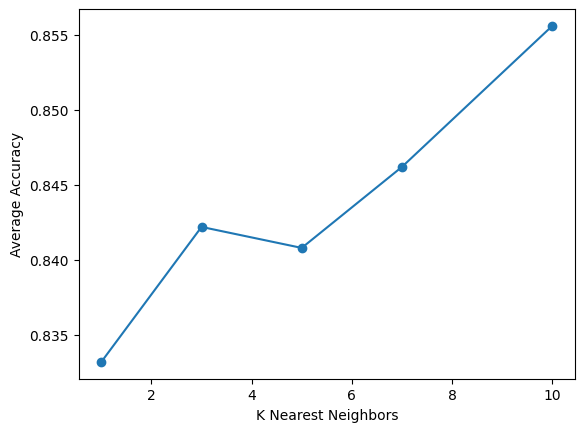

In [10]:
plt.scatter(ks, ave_accuracies)
plt.plot(ks, ave_accuracies)
plt.xlabel("K Nearest Neighbors")
plt.ylabel("Average Accuracy")
plt.savefig('Q3-plot.png')
plt.show()

# Question 5 
### - KNN

In [11]:
#SEE BELOW FOR COMBINED PLOT

df = read_file("emails.csv")
a = 0
b = 1000
k = 5

train_x_df, test_x_df, train_y_df, test_y_df = split_data(df, a, b)
nns = get_nns(train_x_df, test_x_df, k)

real_vals = []
confidences = []
for i in range(len(nns)):
    real_vals.append(df.iloc[i+a]["Prediction"])
    confidences.append(get_prediction(train_y_df, nns, i, return_confidence=True))
    
knn_curve = roc_curve(real_vals, confidences)

# Question 3

In [12]:
# returns dataframe of data after dropping email No. column
def read_file(filename):
    df = pd.read_csv(os.getcwd()+"/data/"+filename, sep=",")
    return df.drop(df.columns[0], axis=1)

# return data with indices between a and b as test_df and all other data as data_df
# drops the prediction column from both dataframes
def split_data(df, a, b):    
    train_df = df.drop(df.index[range(a,b)])
    train_df = train_df.drop(train_df.columns[-1], axis=1)
    
    test_df = df.drop(df.index[range(0,a)]).drop(df.index[range(b,len(df.index))])
    test_df = test_df.drop(test_df.columns[-1], axis=1)
    return train_df, test_df

# returns array of the predictions in training data 
def get_y(df, a):   
    y = (df.loc[np.r_[0:a, a+1000:5000], df.columns == 'Prediction']).to_numpy()  
    return y

# returns sigmoid function of theta and x
def sigmoid(theta, x):
    return 1/(1+np.exp(-x@theta))

# returns theta after taking one step of gradient descent
def take_step(theta, eta, x, y):
    n = train_df.shape[0]
    return theta - 1/n * eta*np.matmul(x.T,(sigmoid(theta,x) - y))

# return weights after training with gradient descent
def train_regression(df, train_df, eta, steps, a):
    theta = np.zeros((3001,1))
    x = train_df.to_numpy()
    y = get_y(df,a)
    
    for i in range(steps):
        theta = take_step(theta, eta, x, y)
        
    return theta

# returns 0 or 1 unless return_confidence is true, 
# then returns confidence in range [0,1]
def make_predictions(theta, test_df, return_confidence=False):
    x = test_df.to_numpy()
    
    if not return_confidence:
        return (sigmoid(theta, x) > 0.5)*1
    
    return sigmoid(theta, x)

# numerator: tp + tn
# denominator: all datapoints
def get_accuracy(df, predictions, a):
    
    num_correct = 0
    for i in range(len(predictions)):     
        real_val = df.iloc[i+a]["Prediction"]
        prediction = predictions[i][0]
    
        if real_val and prediction:
            num_correct += 1
        if not real_val and not prediction:
            num_correct += 1

    return num_correct / 1000

# numerator: (TP)
# denominator: (TP + FP)
def get_precision(df, predictions, a):
    tp = 0
    fp = 0
    for i in range(len(predictions)):
        real_val = df.iloc[i+a]["Prediction"]
        prediction = predictions[i][0]
        
        if real_val and prediction:
            tp += 1
        if not real_val and prediction:
            fp += 1
    
    return tp/(tp+fp)

# numerator: (tp)
# denominator: (tp + fn)
def get_recall(df, predictions, a):
    tp = 0
    fn = 0
    
    for i in range(len(predictions)):
        real_val = df.iloc[i+a]["Prediction"]
        prediction = predictions[i][0]
        
        if real_val and prediction:
            tp += 1
        if real_val and not prediction:
            fn += 1
    
    return tp/(tp + fn)

In [13]:
df = read_file("emails.csv")
folds = [[0,1000],[1000,2000],[2000,3000],[3000,4000],[4000,5000]]
eta = 0.001
steps = 1000


accuracies = []
precisions = []
recalls = []
for i in range(len(folds)):
    a = folds[i][0]
    b = folds[i][1]
    
    train_df, test_df = split_data(df, a, b)
    train_df["b_"] = 1
    test_df["b_"] = 1
    
    theta = train_regression(df, train_df, eta, steps, a)
    predictions = make_predictions(theta, test_df)
    
    accuracies.append(get_accuracy(df, predictions, a))
    precisions.append(get_precision(df, predictions, a))
    recalls.append(get_recall(df, predictions, a))

print("accuracies: ")
for a in accuracies:
    print(a)
    
print("\nprecisions: ")
for p in precisions:
    print(p)
    
print("\nrecalls: ")
for r in recalls:
    print(r)

accuracies: 
0.903
0.901
0.871
0.872
0.849

precisions: 
0.8916666666666667
0.8396946564885496
0.9015544041450777
0.8458333333333333
0.8015564202334631

recalls: 
0.7508771929824561
0.7942238267148014
0.6126760563380281
0.6904761904761905
0.673202614379085


# Question 5
### - Regression

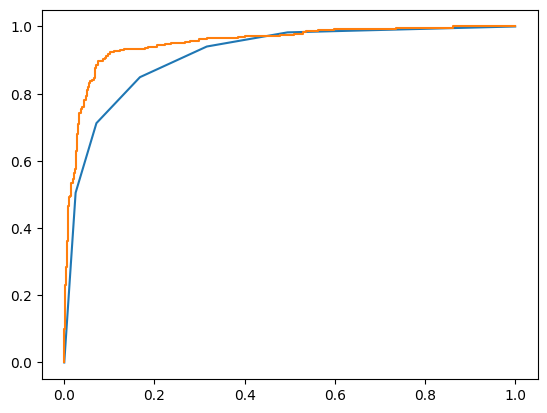

In [14]:
df = read_file("emails.csv")
a = 0
b = 1000
eta = 0.001
steps = 1000

train_df, test_df = split_data(df, a, b)
train_df["b_"] = 1
test_df["b_"] = 1

theta = train_regression(df, train_df, eta, steps, a)
confidences = make_predictions(theta, test_df, return_confidence=True)
real_vals = df.drop(df.index[range(0,a)]).drop(df.index[range(b,len(df.index))]).loc[:,"Prediction"]


regression_curve = roc_curve(real_vals, confidences)

plt.plot(knn_curve[0], knn_curve[1], label="KNN")
plt.plot(regression_curve[0], regression_curve[1], label="Regression")
plt.show()